# Single-Band Period Finding with ``gatspy``

This shows an example of finding single-band periodograms for RR Lyrae data with [``gatspy``](http://github.com/jakevdp/gatspy/)

We'll start by doing some preparatory imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# use seaborn's default plotting styles for matplotlib
import seaborn; seaborn.set()

## Downloading RR Lyrae Data

``gatspy`` includes loaders for some convenient datasets.
Here we'll take a look at some RR Lyrae light curves from [Sesar 2010](http://iopscience.iop.org/0004-637X/708/1/717/)

In [2]:
from gatspy.datasets import fetch_rrlyrae
rrlyrae = fetch_rrlyrae()

This dataset object has an ``ids`` attribute showing the light curve ids available, and a ``get_lightcurve`` method which returns the light curve:

In [3]:
len(rrlyrae.ids)

483

In [4]:
lcid = rrlyrae.ids[0]
t, y, dy, filts = rrlyrae.get_lightcurve(lcid)

Let's quickly visualize this data, to see what we're working with:

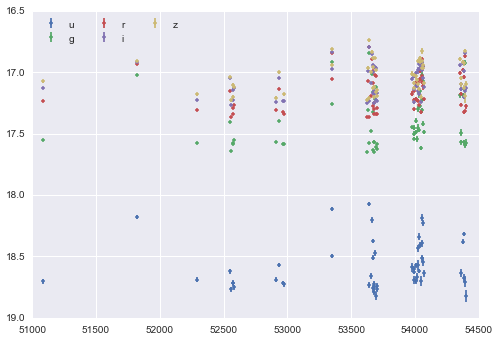

In [5]:
for filt in 'ugriz':
    mask = (filts == filt)
    plt.errorbar(t[mask], y[mask], dy[mask], fmt='.', label=filt)
plt.gca().invert_yaxis()
plt.legend(ncol=3, loc='upper left');

The dataset has a ``metadata`` attribute, which can tell us things like the period (as determined by Sesar 2010:

In [6]:
period = rrlyrae.get_metadata(lcid)['P']
period

0.61431831

Let's fold the lightcurve on this period and re-plot the points:

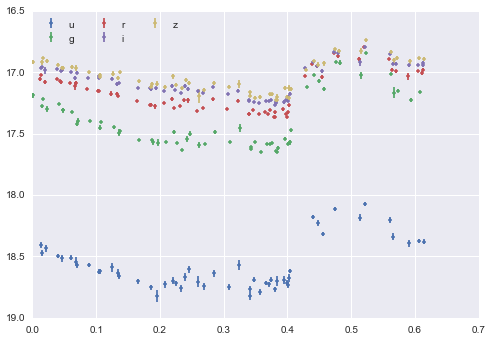

In [7]:
phase = t % period
for filt in 'ugriz':
    mask = (filts == filt)
    plt.errorbar(phase[mask], y[mask], dy[mask], fmt='.', label=filt)
plt.gca().invert_yaxis()
plt.legend(ncol=3, loc='upper left');

Now the characteristic shape of the RR Lyrae light curve can be seen!

## Lomb-Scargle Fits to the Data


### Lomb-Scargle Period finding
We can now use the Lomb-Scargle periodogram to attempt to fit the period.
We'll use the classic (single-band) version, and examine the best period for each band individually. Because of the large (~10 year) baseline, the fit takes a few seconds per band:

In [8]:
from gatspy.periodic import LombScargle, LombScargleFast
# LombScargleFast is slightly faster than LombScargle for the simplest case
# Both have the same interface.

model = LombScargleFast()
model.optimizer.set(quiet=True, period_range=(0.2, 1.2))

print("Sesar 2010:", period)
for filt in 'ugriz':
    mask = (filts == filt)
    model.fit(t[mask], y[mask], dy[mask])
    print(filt + ':         ', model.best_period)

Sesar 2010: 0.614318
u:          0.61431570304
g:          0.614316612117
r:          0.614316612117
i:          0.614317748467
z:          0.614316839386


We see that within each band, the lomb-scargle periodogram lands on the correct peak.
This ``model.best_period`` hides some computation. To find the best period, the model optimizer determines the required resolution for a linear scan search, and computes the periodogram at each of these values.
We can view the periodogram for each model by calling the ``periodogram`` method.
We'll put this in a function for later use

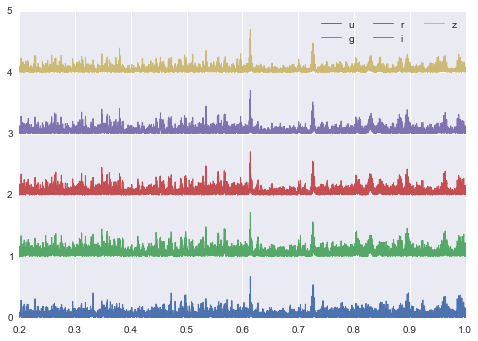

In [9]:
def plot_periodogram(model, lcid):
    plt.figure()
    rrlyrae = fetch_rrlyrae()
    t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
    period = rrlyrae.get_metadata(lcid)['P']
    
    periods = np.linspace(0.2, 1.0, 5000)
    for i, filt in enumerate('ugriz'):
        mask = (filts == filt)
        model.fit(t[mask], y[mask], dy[mask])
        power = model.periodogram(periods)
        plt.plot(periods, i + power, lw=1, label=filt)
    plt.xlim(periods[0], periods[-1])
    plt.ylim(0, 5)
    plt.legend(ncol=3)

plot_periodogram(LombScargle(), lcid)

The periodogram has very narrow peaks, of width approximately $\Delta P \approx P^2 / T$, where $T = (t_{max} - t_{min})$ is the baseline of the measurements. For 10 years of data, the width near the 0.6 day peak turns out to be around $10^{-4}$ days (about 8 seconds), which is why we need such fine sampling of the periodogram to see the peaks.

### Lomb-Scargle Model Fitting

The Lomb-Scargle model corresponds to a single-term sinusoid fit to the data.
We can plot these model fits using the ``predict()`` method.
We'll encapsulate this in a function in order to reuse it below:

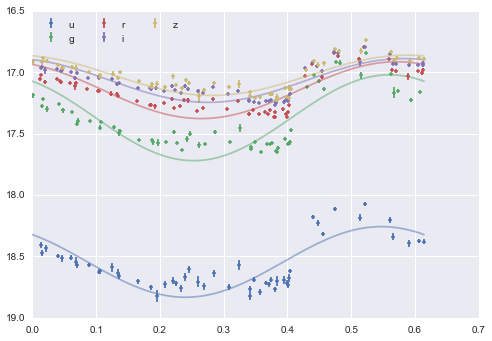

In [10]:
def plot_model(model, lcid):
    plt.figure()
    rrlyrae = fetch_rrlyrae()
    t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
    period = rrlyrae.get_metadata(lcid)['P']

    phase = t % period
    tfit = np.linspace(0, period, 100)
    for filt in 'ugriz':
        mask = (filts == filt)
        pts = plt.errorbar(phase[mask], y[mask], dy[mask], fmt='.', label=filt)
        model.fit(t[mask], y[mask], dy[mask])
        yfit = model.predict(tfit, period=period)
        
        plt.plot(tfit, yfit, color=pts[0].get_color(), alpha=0.5)
    plt.gca().invert_yaxis()
    plt.legend(ncol=3, loc='upper left');
    
plot_model(LombScargle(), lcid)

The model is clearly fairly biased: that is, it doesn't have enough flexibility to truly fit the data. We can do a bit better by adding more terms to the Fourier series with the ``Nterms`` parameter

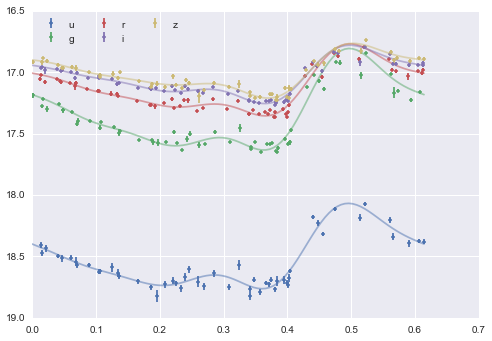

In [11]:
plot_model(LombScargle(Nterms=4), lcid)

This model can also be used within the periodogram, using the same interface as above:

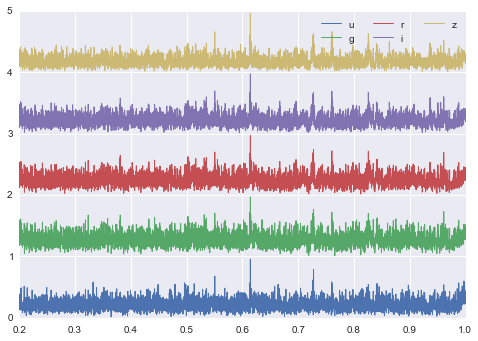

In [12]:
plot_periodogram(LombScargle(Nterms=4), lcid)

## Supersmoother periodogram and fits

The package includes the SuperSmoother algorithm using the same API.
Here we'll plot the periodogram and the model fits for the same data using this model.
Because the interface is identical, we can simply swap-in the supersmoother model in the function from above:

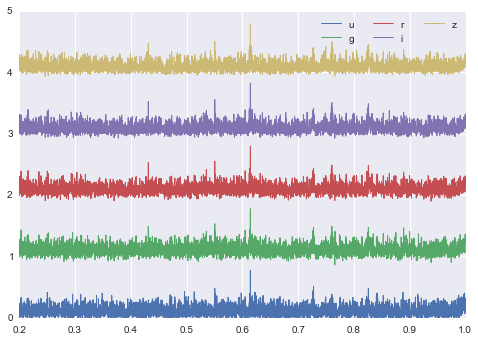

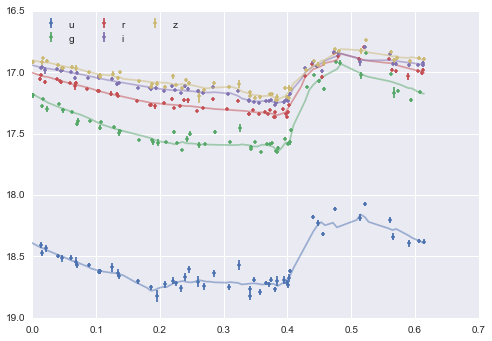

In [13]:
from gatspy.periodic import SuperSmoother
plot_periodogram(SuperSmoother(), lcid)
plot_model(SuperSmoother(), lcid)

Nice and easy!